# Creating a dataset for a visual interpreter
Human caption quality can vary greatly in our dataset, making it hard to see if our model is doing well or if there's an issue with our data. With this code, we aim to generate a representative dataset that includes various image quality issues and good/bad examples of human captions so a professional visual interpreter can provide us with options to run through our experiments.

In [1]:
import json
import os
import requests
import re

from PIL import Image
import io

import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances


import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Load Dataset

In [2]:
data_filepath = "../../data/study-2-output/labeled-data/evaluation-results/computed_atomics_5432-images_2025-04-04_19-18.json"

with open(data_filepath, "r") as f:
    data = json.load(f)

print(json.dumps(data[0:1], indent=4, ensure_ascii=False))

[
    {
        "image_id": 1,
        "file_name": "VizWiz_train_00000001.jpg",
        "vizwiz_url": "https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000001.jpg",
        "text_detected": true,
        "unrecognizable": 0,
        "framing": 0,
        "blur": 5,
        "obstruction": 0,
        "rotation": 0,
        "too dark": 0,
        "too bright": 0,
        "other": 0,
        "no issue": 0,
        "human_captions": [
            {
                "caption": "A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.",
                "is_precanned": false,
                "is_rejected": false
            },
            {
                "caption": "A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.",
                "is_precanned": false,
                "is_rejected": false
            },
            {
                "caption": "A kitchen counter the various items on top including a can of Coc

# Helper functions

## Generating summaries of quality

In [3]:
def calculate_quality_metrics(df, reference_df=None, quality_columns=None):
    """
    Calculate quality issue counts and optionally percentages compared to a reference dataset.

    Args:
        df: DataFrame containing the quality issues data
        reference_df: Optional reference DataFrame to calculate percentages against
        quality_columns: List of quality issue column names. If None, uses default columns

    Returns:
        DataFrame with quality counts, and optionally percentages if reference_df is provided
    """
    if quality_columns is None:
        quality_columns = [
            "unrecognizable",
            "blur",
            "framing",
            "obstruction",
            "rotation",
            "too dark",
            "too bright",
            "other",
            "no issue",
        ]

    # Calculate counts
    quality_counts = pd.concat(
        [df[col].value_counts() for col in quality_columns], axis=1
    )
    quality_counts.columns = quality_columns

    # Replace NaN with 0 and convert to int
    quality_counts = quality_counts.fillna(0).astype(int)

    # sort index from 0 to 5
    quality_counts = quality_counts.sort_index()

    # Add total row
    quality_counts.loc["total"] = quality_counts.sum()

    # Calculate percentages if reference DataFrame is provided
    if reference_df is not None:
        reference_counts = calculate_quality_metrics(
            reference_df, quality_columns=quality_columns
        )
        quality_percentages = quality_counts.div(reference_counts, axis=0) * 100
        return quality_percentages.round(2)

    return quality_counts


def combine_counts_and_percentages(counts_df, percentages_df=None):
    """
    Combines counts and percentages into a single DataFrame with formatted strings.

    Args:
        counts_df: DataFrame containing the counts
        percentages_df: Optional DataFrame containing percentages. If None, percentages
                       will be calculated using the total row of counts_df

    Returns:
        DataFrame with formatted strings combining counts and percentages
    """
    # Calculate percentages if not provided
    if percentages_df is None:
        percentages_df = (counts_df.div(counts_df.loc["total"], axis=1) * 100).round(2)

    def format_count_and_percentage(count, percentage):
        count_str = (
            str(int(float(count))) if float(count).is_integer() else str(float(count))
        )
        return f"{count_str} ({percentage:.2f}%)"

    # Create combined DataFrame
    combined_stats = pd.DataFrame(
        [
            [
                format_count_and_percentage(count, pct)
                for count, pct in zip(row_counts, row_pcts)
            ]
            for row_counts, row_pcts in zip(counts_df.values, percentages_df.values)
        ],
        index=counts_df.index,
        columns=counts_df.columns,
    )

    return combined_stats

## Computing sentence similarity with BERT

In [4]:
def get_sentences_from_human_captions(data_for_image):
    return [
        caption["caption"]
        for caption in data_for_image["human_captions"]
        if caption["caption"]
        != "Quality issues are too severe to recognize visual content."
    ]

In [5]:
def compute_caption_similarity(
    captions, model=SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
):  # Step 3: Generate sentence embeddings
    embeddings = model.encode(captions)

    # Step 4: Compute pairwise cosine distances
    pairwise_dist = cosine_distances(embeddings)

    # Step 5: Extract upper triangle of distance matrix (excluding diagonal)
    triu_indices = np.triu_indices(len(captions), k=1)
    similarities = pairwise_dist[triu_indices]

    return similarities, pairwise_dist

In [6]:
def compute_similiary_stats(similiarity_list):
    # Step 6: Compute stats
    min_similarity = np.min(similiarity_list)
    max_similarity = np.max(similiarity_list)
    mean_similarity = np.mean(similiarity_list)
    std_similarity = np.std(similiarity_list)
    variance_similarity = np.var(similiarity_list)

    return (
        min_similarity,
        max_similarity,
        mean_similarity,
        std_similarity,
        variance_similarity,
    )

In [7]:
def plot_pairwise_distances(pairwise_distances, sentences):
    def truncate(sentence, max_words=10):
        words = sentence.split()
        return " ".join(words[:max_words]) + ("..." if len(words) > max_words else "")

    short_labels = [truncate(s, max_words=10) for s in sentences]

    # Plot heatmap with cleaned-up labels
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        pairwise_distances,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        xticklabels=short_labels,
        yticklabels=short_labels,
        annot_kws={"size": 9},
    )
    plt.title("Sentence Dissimilarity Heatmap (Cosine Distance)", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    return plt

## Picking examples based on sentence similarity

In [8]:
def get_n_lowest_scoring(dataset, n=5, metric="mean_similarity"):
    """
    Returns the n lowest scoring images based on metric similarity.
    """
    # Sort the dataset based on the specified similarity metric
    sorted_dataset = sorted(
        dataset, key=lambda x: x["human_caption_similarity"][metric]
    )

    # Return the n lowest scoring images
    return sorted_dataset[:n]


def get_n_highest_scoring(dataset, n=5, metric="mean_similarity"):
    """
    Returns the n highest scoring images based on metric similarity.
    """
    # Sort the dataset based on the specified similarity metric in descending order
    sorted_dataset = sorted(
        dataset, key=lambda x: x["human_caption_similarity"][metric], reverse=True
    )

    # Return the n highest scoring images
    return sorted_dataset[:n]

## Plotting Code

In [9]:
def plot_grid_of_pairwise_distances(dataset):
    def truncate(sentence, max_words=5):
        words = sentence.split()
        return " ".join(words[:max_words]) + ("..." if len(words) > max_words else "")

    # Create a grid of pairwise distance heatmaps
    n_images = len(dataset)
    n_rows = 2
    n_cols = (n_images + n_rows - 1) // n_rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, 30))
    for i, image in enumerate(dataset):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]

        short_labels = [
            truncate(s, max_words=10)
            for s in image["human_caption_similarity"]["sentences"]
        ]

        # Plot heatmap with cleaned-up labels
        sns.heatmap(
            image["human_caption_similarity"]["pairwise_distances"],
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            xticklabels=short_labels,
            yticklabels=short_labels,
            annot_kws={"size": 16},
            ax=ax,
        )

        # rotate xticks
        ax.set_title(
            f"Average similarity: {image['human_caption_similarity']['mean_similarity']:.4f}; Min similarity: {image['human_caption_similarity']['min_similarity']:.4f}; Max similarity: {image['human_caption_similarity']['max_similarity']:.4f};\nStd similarity: {image['human_caption_similarity']['std_similarity']:.4f}; Variance similarity: {image['human_caption_similarity']['variance_similarity']:.4f}\nCosine distance (0 is most similar; 1 is least similar)",
            fontsize=24,
            y=1.05,
            x=0.5,
            horizontalalignment="center",
            verticalalignment="center",
            bbox=dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.5"),
            transform=ax.transAxes,
        )

        # print sentences under the heatmap
        ax.set_xlabel(
            "\n".join(image["human_caption_similarity"]["sentences"]),
            fontsize=18,
            y=0.5,
            x=0.5,
        )
    plt.tight_layout()
    plt.show()


def plot_images_grid(dataset, n_rows=2, n_cols=3, figsize=(50, 30)):
    """
    Plot a grid of images from the dataset.

    Args:
        dataset: List of dictionaries containing image data
        n_rows: Number of rows in the grid
        n_cols: Number of columns in the grid
        figsize: Figure size (width, height)
    """
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Flatten axes array for easier indexing if there are multiple rows
    if n_rows > 1:
        axes = axes.flatten()

    for i, image_data in enumerate(dataset):
        if i >= n_rows * n_cols:
            break

        # Get image URL
        image_name = image_data["file_name"]
        img_url = image_data["vizwiz_url"]

        # Display image directly from URL
        try:
            # Use requests and PIL to load and display the image from URL
            response = requests.get(img_url)
            img = Image.open(io.BytesIO(response.content))

            if n_rows == 1 and n_cols == 1:
                axes.imshow(np.array(img))
                axes.set_title(f"Image {image_name}", fontsize=24)
                axes.axis("off")
            else:
                axes[i].imshow(np.array(img))
                axes[i].set_title(f"Image {image_name}", fontsize=24)
                axes[i].axis("off")
        except Exception as e:
            print(f"Error loading image {i+1}: {e}")
            if n_rows == 1 and n_cols == 1:
                axes.text(
                    0.5, 0.5, f"Error loading image: {e}", ha="center", va="center"
                )
                axes.axis("off")
            else:
                axes[i].text(
                    0.5, 0.5, f"Error loading image: {e}", ha="center", va="center"
                )
                axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Compute Sentence Similarity using S-BERT
One approach to identifying noisy captions- where human captioners disagree or caption very different things- is to look at their semantic similarity. We can use SentenceBERT to compute embeddings and then do pair-wise cosine distance between sentences. When we compute the min/max/average/standard deviation on these pair-wise comparisons, we can have a heuristic for which sets of captions are more / less consistent. Cosine distance scores range from 0 to 2 where:
- 2 suggests that sentences are diametrically opposite (though in practice, cosine distance is usually 0-1)
- 0 means the vectors are perfectly aligned, which indicates they are identical

So, closer to 0 means the captions are similar, whereas closer to 1 means the captions are more dissimilar.


In [10]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
for curr_image in tqdm(data):
    curr_sentences = get_sentences_from_human_captions(curr_image)
    curr_similarities, pairwise_dist = compute_caption_similarity(
        get_sentences_from_human_captions(curr_image), model
    )
    curr_stats = compute_similiary_stats(curr_similarities)

    curr_image["human_caption_similarity"] = {
        "sentences": curr_sentences,
        "similarities": [float(x) for x in curr_similarities],
        "pairwise_distances": pairwise_dist,
        "min_similarity": float(curr_stats[0]),
        "max_similarity": float(curr_stats[1]),
        "mean_similarity": float(curr_stats[2]),
        "std_similarity": float(curr_stats[3]),
        "variance_similarity": float(curr_stats[4]),
    }
print(data[0:1])

  0%|          | 0/5432 [00:00<?, ?it/s]

[{'image_id': 1, 'file_name': 'VizWiz_train_00000001.jpg', 'vizwiz_url': 'https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00000001.jpg', 'text_detected': True, 'unrecognizable': 0, 'framing': 0, 'blur': 5, 'obstruction': 0, 'rotation': 0, 'too dark': 0, 'too bright': 0, 'other': 0, 'no issue': 0, 'human_captions': [{'caption': 'A can of Coca Cola on a counter is shown for when one can use a nice, cold drink.', 'is_precanned': False, 'is_rejected': False}, {'caption': 'A black can of Coca Cola Zero calorie soda is on the counter near the coffee maker.', 'is_precanned': False, 'is_rejected': False}, {'caption': 'A kitchen counter the various items on top including a can of Coca-Cola, metal containers, and a teapot.', 'is_precanned': False, 'is_rejected': False}, {'caption': 'a black tin of Coca Cola placed on a black surface', 'is_precanned': False, 'is_rejected': False}, {'caption': 'Black counter with canisters, kettle and can of soda.', 'is_precanned': False, 'is_

In [11]:
if isinstance(data, list):
    sentence_embedding_df = pd.DataFrame(data)
    # expand the human_caption_similarity column
    sentence_embedding_df = pd.concat(
        [
            sentence_embedding_df,
            pd.json_normalize(sentence_embedding_df["human_caption_similarity"]),
        ],
        axis=1,
    )
else:
    sentence_embedding_df = data

In [12]:
sentence_embedding_df.head()

,image_id,file_name,vizwiz_url,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,...,evaluation,human_caption_similarity,sentences,similarities,pairwise_distances,min_similarity,max_similarity,mean_similarity,std_similarity,variance_similarity
0,1,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,5,0,0,0,...,{'bertscore': {'gpt-4o-2024-08-06': {'scores':...,{'sentences': ['A can of Coca Cola on a counte...,[A can of Coca Cola on a counter is shown for ...,"[0.32641178369522095, 0.42414015531539917, 0.4...","[[0.0, 0.32641178, 0.42414016, 0.44875127, 0.3...",0.237859,0.619006,0.419898,0.100428,0.010086
1,8,VizWiz_train_00000008.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,0,0,0,...,{'bertscore': {'gpt-4o-2024-08-06': {'scores':...,{'sentences': ['candy with pink color to eat a...,[candy with pink color to eat and enjoy and te...,"[0.741274356842041, 0.5772005319595337, 0.4438...","[[0.0, 0.74127436, 0.57720053, 0.44387245, 0.4...",0.239310,0.741274,0.539343,0.179493,0.032218
2,11,VizWiz_train_00000011.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,2,2,4,1,1,...,{'bertscore': {'gpt-4o-2024-08-06': {'scores':...,{'sentences': ['imagine how you would describe...,[imagine how you would describe this image on ...,"[0.7961530685424805, 0.8145391941070557, 0.799...","[[0.0, 0.79615307, 0.8145392, 0.7991368, 0.930...",0.362963,0.930371,0.654941,0.164919,0.027198
3,20,VizWiz_train_00000020.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,1,0,0,...,{'bertscore': {'gpt-4o-2024-08-06': {'scores':...,{'sentences': ['A copy of Grand theft auto vic...,[A copy of Grand theft auto vice city for Play...,"[0.33500468730926514, 0.19939720630645752, 0.1...","[[0.0, 0.3350047, 0.1993972, 0.1660229, 0.1956...",0.166023,0.438796,0.280228,0.090708,0.008228
4,26,VizWiz_train_00000026.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,4,0,0,0,...,{'bertscore': {'gpt-4o-2024-08-06': {'scores':...,{'sentences': ['The photo is of a bottle of ...,[The photo is of a bottle of some sort of sl...,"[0.32707613706588745, 0.36659562587738037, 0.4...","[[0.0, 0.32707614, 0.36659563, 0.45651925, 0.3...",0.157597,0.533225,0.349985,0.122182,0.014928


## Export the whole dataset
This is the first dataset we have that has sentence similarity in it. So, let's export it so we can examine in manually outside of this notebook

In [13]:
# expand human captions into separate columns with names human_caption_1, human_caption_2, etc.
whole_data_export_df = pd.concat(
    [
        sentence_embedding_df,
        pd.json_normalize(sentence_embedding_df["human_captions"]).rename(
            columns=lambda x: f"human_caption_{x +1}"
        ),
        pd.json_normalize(sentence_embedding_df["model_captions"]).rename(
            columns=lambda x: [
                "gpt-4o-2024-08-06",
                "Llama-3.2-11B-Vision-Instruct",
                "Molmo-7B-O-0924",
            ][x]
        ),
    ],
    axis=1,
)

# for each human caption column, replace content with just caption text
for col in whole_data_export_df.columns:
    if re.search(r"human_caption_\d+", col):
        whole_data_export_df[col] = whole_data_export_df[col].apply(
            lambda x: x["caption"]
        )

    if col in [
        "gpt-4o-2024-08-06",
        "Llama-3.2-11B-Vision-Instruct",
        "Molmo-7B-O-0924",
    ]:
        whole_data_export_df[col] = whole_data_export_df[col].apply(
            lambda x: x["caption"]
        )

# delete the human_captions and model_captions columns
whole_data_export_df = whole_data_export_df.drop(
    columns=["human_captions", "model_captions"]
)

whole_data_export_df.head()

,image_id,file_name,vizwiz_url,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,...,std_similarity,variance_similarity,human_caption_1,human_caption_2,human_caption_3,human_caption_4,human_caption_5,gpt-4o-2024-08-06,Llama-3.2-11B-Vision-Instruct,Molmo-7B-O-0924
0,1,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,5,0,0,0,...,0.100428,0.010086,A can of Coca Cola on a counter is shown for w...,A black can of Coca Cola Zero calorie soda is ...,A kitchen counter the various items on top inc...,a black tin of Coca Cola placed on a black sur...,"Black counter with canisters, kettle and can o...",A can of Coca-Cola Zero is on a kitchen counte...,The image shows a black can with a yellow band...,A black and yellow can of Coca-Cola is promine...
1,8,VizWiz_train_00000008.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,0,0,0,...,0.179493,0.032218,candy with pink color to eat and enjoy and tex...,a yellow color cheese is packed in a transpare...,a sachet packaged of Farley' s Orange Slices,"Tasty, orange, jelly candies are in this bag.",Plastic bag of Farley's brand orange slice can...,A package of Farley's orange slice candies lab...,The image shows a clear plastic bag filled wit...,A clear plastic bag containing orange slices i...
2,11,VizWiz_train_00000011.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,2,2,4,1,1,...,0.164919,0.027198,imagine how you would describe this image on t...,the photographer's hand holding a round bottle...,canned food held by a man's fingers with the t...,A person holding a food can with the rear of t...,A White man's hand holding a Vitamin Bottle.,A hand holding the top of a can with a red and...,The image shows a thumb with a fingernail pain...,The image shows a hand holding a cylindrical o...
3,20,VizWiz_train_00000020.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,1,0,0,...,0.090708,0.008228,A copy of Grand theft auto vice city for PlayS...,"Most of grand theft auto vice, a video game, i...",a PlayStation 2 CD pack of Grand Theft Auto,A case of the game grand theft auto vice city ...,The front of a copy of the Grand Theft Auto Vi...,"A PlayStation 2 game case for ""Grand Theft Aut...",The image shows a video game case with the tit...,A PlayStation 2 game case for Grand Theft Auto...
4,26,VizWiz_train_00000026.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,4,0,0,0,...,0.122182,0.014928,The photo is of a bottle of some sort of sle...,"A purple bottle with the word ""sleep"" on the f...",blue and sparkly bottle with the word sleep wr...,Front label of an small plastic bottle contain...,A small blue bottle with little sparkles on it...,"A purple bottle labeled ""Sleep"" with text indi...",The image shows a purple bottle with a label f...,The image shows a purple bottle lying on its s...


In [14]:
# setup output path
output_path = "../../data/study-2-output/visual-interpreter-dataset/"
os.makedirs(output_path, exist_ok=True)

# save dataset_3 as a csv with everything
dataset3_raw = whole_data_export_df.copy()
del dataset3_raw["evaluation"]
del dataset3_raw["human_caption_similarity"]
del dataset3_raw["sentences"]
del dataset3_raw["similarities"]
del dataset3_raw["pairwise_distances"]
dataset3_raw.to_csv(output_path + "whole_dataset.csv", index=False)

## Analyzing sentence embeddings
Now that we have sentence embeddings, let's look at the consistency in captions. Our goal is to identify whether these scores can reliably tell us that the caption quality is problematic.

### Mean similarity
Start by looking at the average similarity across human captions. The idea is that captions which have lower average similarity are less diverse, indicating there is more consensus on what the image is.

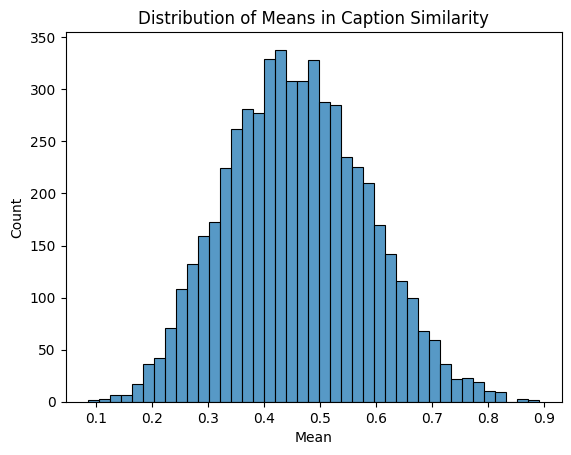

In [15]:
# plot a histogram of the Means
sns.histplot(sentence_embedding_df, x="mean_similarity")
plt.title("Distribution of Means in Caption Similarity")
plt.xlabel("Mean")
plt.ylabel("Count")
plt.show()

Data looks approximately normal above, and based on the QQ-plot

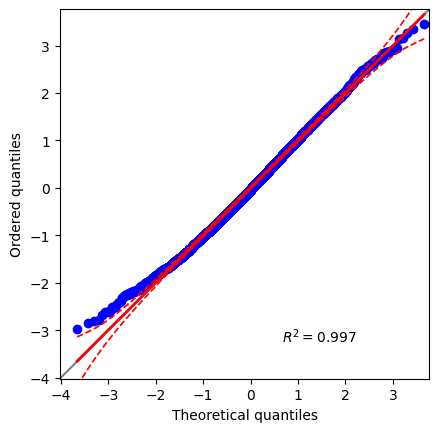

In [16]:
ax = pg.qqplot(
    sentence_embedding_df["mean_similarity"].dropna(), dist="norm", confidence=0.95
)

#### Show top and bottom 6 images for mean of pairwise similarity

In [17]:
# plot_images_grid(get_n_lowest_scoring(data, n=6))
# plot_grid_of_pairwise_distances(get_n_lowest_scoring(data, n=6))

In [18]:
# plot_images_grid(get_n_highest_scoring(data, n=6))
# plot_grid_of_pairwise_distances(get_n_highest_scoring(data, n=6))

In [19]:
# get a list of best and worst performing images based on mean_similarity
best_images = get_n_lowest_scoring(data, n=10, metric="mean_similarity")
worst_images = get_n_highest_scoring(data, n=10, metric="mean_similarity")

# print just the file_names
print(f"Best images: {[image['file_name'] for image in best_images]}")
print(f"Worst images: {[image['file_name'] for image in worst_images]}")

Best images: ['VizWiz_train_00021660.jpg', 'VizWiz_train_00016884.jpg', 'VizWiz_train_00013883.jpg', 'VizWiz_train_00006346.jpg', 'VizWiz_train_00019576.jpg', 'VizWiz_train_00014489.jpg', 'VizWiz_train_00017921.jpg', 'VizWiz_train_00000764.jpg', 'VizWiz_train_00020137.jpg', 'VizWiz_train_00018577.jpg']
Worst images: ['VizWiz_train_00015945.jpg', 'VizWiz_train_00015358.jpg', 'VizWiz_train_00019128.jpg', 'VizWiz_train_00015003.jpg', 'VizWiz_train_00005172.jpg', 'VizWiz_train_00012202.jpg', 'VizWiz_train_00004022.jpg', 'VizWiz_train_00023243.jpg', 'VizWiz_train_00008517.jpg', 'VizWiz_train_00006718.jpg']


#### Computing quartiles, outliers, and standard deviation cut-offs
These numbers should hold with the normal interpretation since the distribution is mostly normal. In this case: 
- 1 stdev = top and bottom 16% if mean similarities
- 2 stdev = top and bottom 2.5% if mean similarities

In [20]:
# get quartiles
q1, q2, q3 = sentence_embedding_df["mean_similarity"].quantile([0.25, 0.5, 0.75])
print(f"Min: {min(sentence_embedding_df['mean_similarity']):.4f}")
print(f"Q1 (25th percentile): {q1:.4f}")
print(f"Q2 (median): {q2:.4f}")
print(f"Q3 (75th percentile): {q3:.4f}")
print(f"Max: {max(sentence_embedding_df['mean_similarity']):.4f}")
print(f"Interquartile range (IQR): {q3-q1:.4f}")

# define outliers (1.5 * IQR method)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(f"Lower bound for outliers (-I.5 * IQR): {lower_bound:.4f}")
print(f"Upper bound for outliers (+1.5 * IQR): {upper_bound:.4f}")

print("\n")

# compute 1 and 2 standard deviations away
mean = sentence_embedding_df["mean_similarity"].mean()
std = sentence_embedding_df["mean_similarity"].std()
print(f"Mean: {mean:.4f}")
print(f"Standard deviation: {std:.4f}")
print(f"Mean - 1 std: {mean - std:.4f}")
print(f"Mean + 1 std: {mean + std:.4f}")
print(f"Mean - 2 std: {mean - 2*std:.4f}")
print(f"Mean + 2 std: {mean + 2*std:.4f}")

Min: 0.0864
Q1 (25th percentile): 0.3701
Q2 (median): 0.4550
Q3 (75th percentile): 0.5455
Max: 0.8909
Interquartile range (IQR): 0.1755
Lower bound for outliers (-I.5 * IQR): 0.1068
Upper bound for outliers (+1.5 * IQR): 0.8087


Mean: 0.4594
Standard deviation: 0.1252
Mean - 1 std: 0.3342
Mean + 1 std: 0.5846
Mean - 2 std: 0.2091
Mean + 2 std: 0.7098


#### Subsets of data based on quartile cut-offs
Let's start subsetting the data based on the quartiles.

In [21]:
# setup which issues to filter on
issues_to_filter = [
    "blur",
    "framing",
    "obstruction",
    "rotation",
    "too dark",
    "too bright",
]

In [32]:
# look at 25th percentile and under
q1 = float(sentence_embedding_df["mean_similarity"].quantile([0.25]))
sentence_embedding_mean25_df = sentence_embedding_df[
    sentence_embedding_df["mean_similarity"] < q1
]
sentence_embedding_mean25_df_quality_counts = calculate_quality_metrics(
    sentence_embedding_mean25_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
sentence_embedding_mean25_df_quality_counts

combine_counts_and_percentages(sentence_embedding_mean25_df_quality_counts)

/var/folders/6w/gkg9vw3d29jglv9knrxxf3r40000gn/T/ipykernel_58146/35983613.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  q1 = float(sentence_embedding_df["mean_similarity"].quantile([0.25]))


,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,1054 (77.61%),342 (25.18%),213 (15.68%),1206 (88.81%),781 (57.51%),1136 (83.65%),1160 (85.42%)
1,240 (17.67%),190 (13.99%),161 (11.86%),117 (8.62%),126 (9.28%),164 (12.08%),142 (10.46%)
2,64 (4.71%),124 (9.13%),166 (12.22%),12 (0.88%),91 (6.70%),40 (2.95%),33 (2.43%)
3,0 (0.00%),96 (7.07%),174 (12.81%),5 (0.37%),89 (6.55%),4 (0.29%),8 (0.59%)
4,0 (0.00%),349 (25.70%),436 (32.11%),13 (0.96%),196 (14.43%),10 (0.74%),9 (0.66%)
5,0 (0.00%),257 (18.92%),208 (15.32%),5 (0.37%),75 (5.52%),4 (0.29%),6 (0.44%)
total,1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%)


In [33]:
# look at 75th percentile and above
q3 = float(sentence_embedding_df["mean_similarity"].quantile([0.75]))
sentence_embedding_mean75_df = sentence_embedding_df[
    sentence_embedding_df["mean_similarity"] > q3
]
sentence_embedding_mean75_df_quality_counts = calculate_quality_metrics(
    sentence_embedding_mean75_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
sentence_embedding_mean75_df_quality_counts

combine_counts_and_percentages(sentence_embedding_mean75_df_quality_counts)

/var/folders/6w/gkg9vw3d29jglv9knrxxf3r40000gn/T/ipykernel_58146/91154046.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  q3 = float(sentence_embedding_df["mean_similarity"].quantile([0.75]))


,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,708 (52.14%),273 (20.10%),106 (7.81%),1141 (84.02%),719 (52.95%),1088 (80.12%),1093 (80.49%)
1,426 (31.37%),177 (13.03%),149 (10.97%),166 (12.22%),201 (14.80%),200 (14.73%),192 (14.14%)
2,224 (16.49%),131 (9.65%),200 (14.73%),20 (1.47%),149 (10.97%),49 (3.61%),46 (3.39%)
3,0 (0.00%),112 (8.25%),190 (13.99%),7 (0.52%),104 (7.66%),11 (0.81%),11 (0.81%)
4,0 (0.00%),356 (26.22%),522 (38.44%),15 (1.10%),144 (10.60%),8 (0.59%),13 (0.96%)
5,0 (0.00%),309 (22.75%),191 (14.06%),9 (0.66%),41 (3.02%),2 (0.15%),3 (0.22%)
total,1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%)


### Standard deviation in similarity
Now, let's look at the standard deviation in pairwise caption similarity. This tells us how spread out the similarities are. The idea is that higher standard deviation indicates cases where some human captioners have significantly different answers than others do.

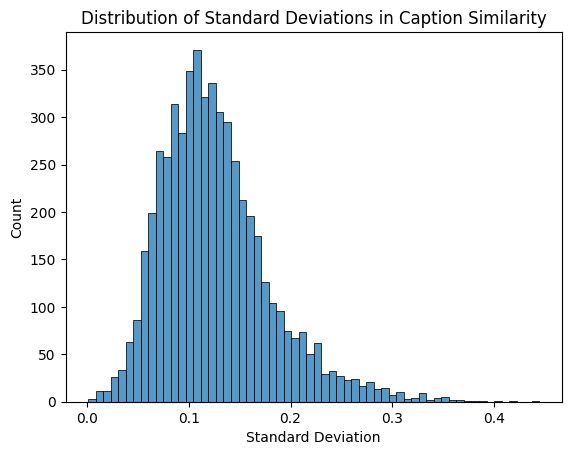

In [34]:
# plot a histogram of the standard deviations
sns.histplot(sentence_embedding_df, x="std_similarity")
plt.title("Distribution of Standard Deviations in Caption Similarity")
plt.xlabel("Standard Deviation")
plt.ylabel("Count")
plt.show()

#### Show top and bottom 5 images for stdev of pairwise similarity

In [35]:
# plot_images_grid(get_n_lowest_scoring(data, n=6, metric="std_similarity"))
# plot_grid_of_pairwise_distances(
#     get_n_lowest_scoring(data, n=6, metric="std_similarity")
# )

In [36]:
# plot_images_grid(get_n_highest_scoring(data, n=6, metric="std_similarity"))
# plot_grid_of_pairwise_distances(
#     get_n_highest_scoring(data, n=6, metric="std_similarity")
# )

In [37]:
# get a list of best and worst performing images based on std_similarity
best_images = get_n_lowest_scoring(data, n=10, metric="std_similarity")
worst_images = get_n_highest_scoring(data, n=10, metric="std_similarity")

# print just the file_names
print(f"Best images: {[image['file_name'] for image in best_images]}")
print(f"Worst images: {[image['file_name'] for image in worst_images]}")

Best images: ['VizWiz_train_00020891.jpg', 'VizWiz_train_00018965.jpg', 'VizWiz_train_00020120.jpg', 'VizWiz_train_00008505.jpg', 'VizWiz_train_00005871.jpg', 'VizWiz_train_00001766.jpg', 'VizWiz_train_00005470.jpg', 'VizWiz_train_00002738.jpg', 'VizWiz_train_00013354.jpg', 'VizWiz_train_00003336.jpg']
Worst images: ['VizWiz_train_00012649.jpg', 'VizWiz_train_00005084.jpg', 'VizWiz_train_00004622.jpg', 'VizWiz_train_00017721.jpg', 'VizWiz_train_00020365.jpg', 'VizWiz_train_00012829.jpg', 'VizWiz_train_00005250.jpg', 'VizWiz_train_00013555.jpg', 'VizWiz_train_00004547.jpg', 'VizWiz_train_00006425.jpg']


#### Computing quartiles, outliers, and standard deviation cut-offs
In this case, the data is heavily skewed right.

In [38]:
# get quartiles
q1, q2, q3 = sentence_embedding_df["std_similarity"].quantile([0.25, 0.5, 0.75])
print(f"Min: {min(sentence_embedding_df['std_similarity']):.4f}")
print(f"Q1 (25th percentile): {q1:.4f}")
print(f"Q2 (median): {q2:.4f}")
print(f"Q3 (75th percentile): {q3:.4f}")
print(f"Max: {max(sentence_embedding_df['std_similarity']):.4f}")
print(f"Interquartile range (IQR): {q3-q1:.4f}\n")

# define outliers (1.5 * IQR method)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print(f"Lower bound for outliers (-I.5 * IQR): {lower_bound:.4f}")
print(f"Upper bound for outliers (+1.5 * IQR): {upper_bound:.4f}\n")

# compute 1 and 2 standard deviations away
mean = sentence_embedding_df["std_similarity"].mean()
std = sentence_embedding_df["std_similarity"].std()
print(f"Mean: {mean:.4f}")
print(f"Standard deviation: {std:.4f}")
print(f"Mean - 1 std: {mean - std:.4f}")
print(f"Mean + 1 std: {mean + std:.4f}")
print(f"Mean - 2 std: {mean - 2*std:.4f}")
print(f"Mean + 2 std: {mean + 2*std:.4f}")

Min: 0.0011
Q1 (25th percentile): 0.0883
Q2 (median): 0.1187
Q3 (75th percentile): 0.1534
Max: 0.4443
Interquartile range (IQR): 0.0651

Lower bound for outliers (-I.5 * IQR): -0.0094
Upper bound for outliers (+1.5 * IQR): 0.2511

Mean: 0.1261
Standard deviation: 0.0544
Mean - 1 std: 0.0718
Mean + 1 std: 0.1805
Mean - 2 std: 0.0174
Mean + 2 std: 0.2348


#### Subsets of data based on quartile cut-offs
Let's start subsetting the data based on the quartiles.

In [39]:
# setup which issues to filter on
issues_to_filter = [
    "blur",
    "framing",
    "obstruction",
    "rotation",
    "too dark",
    "too bright",
]

In [40]:
# look at 10th percentile and under
# including this here since we suspect low stdev is because there's fewer captioners
q10 = float(sentence_embedding_df["std_similarity"].quantile(0.1))
sentence_embedding_stdev10_df = sentence_embedding_df[
    sentence_embedding_df["std_similarity"] < q10
]
sentence_embedding_stdev10_df_quality_counts = calculate_quality_metrics(
    sentence_embedding_stdev10_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
sentence_embedding_stdev10_df_quality_counts

combine_counts_and_percentages(sentence_embedding_stdev10_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,263 (48.35%),113 (20.77%),49 (9.01%),442 (81.25%),317 (58.27%),436 (80.15%),432 (79.41%)
1,136 (25.00%),74 (13.60%),55 (10.11%),85 (15.62%),63 (11.58%),78 (14.34%),73 (13.42%)
2,145 (26.65%),48 (8.82%),63 (11.58%),7 (1.29%),57 (10.48%),21 (3.86%),27 (4.96%)
3,0 (0.00%),34 (6.25%),81 (14.89%),2 (0.37%),35 (6.43%),4 (0.74%),5 (0.92%)
4,0 (0.00%),137 (25.18%),207 (38.05%),6 (1.10%),54 (9.93%),4 (0.74%),6 (1.10%)
5,0 (0.00%),138 (25.37%),89 (16.36%),2 (0.37%),18 (3.31%),1 (0.18%),1 (0.18%)
total,544 (100.00%),544 (100.00%),544 (100.00%),544 (100.00%),544 (100.00%),544 (100.00%),544 (100.00%)


In [41]:
# look at 25th percentile and under
sentence_embedding_stdev25_df = sentence_embedding_df[
    sentence_embedding_df["std_similarity"] < q1
]
sentence_embedding_stdev25_df_quality_counts = calculate_quality_metrics(
    sentence_embedding_stdev25_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
sentence_embedding_stdev25_df_quality_counts

combine_counts_and_percentages(sentence_embedding_stdev25_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,790 (58.17%),307 (22.61%),145 (10.68%),1152 (84.83%),798 (58.76%),1115 (82.11%),1105 (81.37%)
1,347 (25.55%),177 (13.03%),137 (10.09%),166 (12.22%),149 (10.97%),178 (13.11%),170 (12.52%)
2,221 (16.27%),124 (9.13%),161 (11.86%),17 (1.25%),118 (8.69%),42 (3.09%),56 (4.12%)
3,0 (0.00%),109 (8.03%),192 (14.14%),6 (0.44%),93 (6.85%),10 (0.74%),12 (0.88%)
4,0 (0.00%),340 (25.04%),506 (37.26%),11 (0.81%),152 (11.19%),8 (0.59%),11 (0.81%)
5,0 (0.00%),301 (22.16%),217 (15.98%),6 (0.44%),48 (3.53%),5 (0.37%),4 (0.29%)
total,1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%)


In [42]:
# look at 75th percentile and under
sentence_embedding_stdev75_df = sentence_embedding_df[
    sentence_embedding_df["std_similarity"] > q3
]
sentence_embedding_stdev75_df_quality_counts = calculate_quality_metrics(
    sentence_embedding_stdev75_df,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
sentence_embedding_stdev75_df_quality_counts

combine_counts_and_percentages(sentence_embedding_stdev75_df_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,985 (72.53%),298 (21.94%),136 (10.01%),1185 (87.26%),720 (53.02%),1126 (82.92%),1113 (81.96%)
1,298 (21.94%),200 (14.73%),184 (13.55%),138 (10.16%),193 (14.21%),186 (13.70%),184 (13.55%)
2,75 (5.52%),125 (9.20%),173 (12.74%),9 (0.66%),115 (8.47%),32 (2.36%),39 (2.87%)
3,0 (0.00%),115 (8.47%),155 (11.41%),7 (0.52%),98 (7.22%),6 (0.44%),8 (0.59%)
4,0 (0.00%),361 (26.58%),524 (38.59%),15 (1.10%),185 (13.62%),6 (0.44%),9 (0.66%)
5,0 (0.00%),259 (19.07%),186 (13.70%),4 (0.29%),47 (3.46%),2 (0.15%),5 (0.37%)
total,1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%)


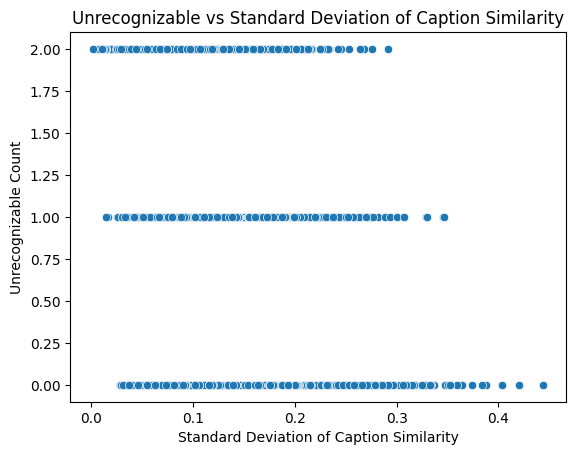

In [43]:
# create a scatterplot of unrecognizable and std_similarity
sns.scatterplot(data=sentence_embedding_df, x="std_similarity", y="unrecognizable")
plt.title("Unrecognizable vs Standard Deviation of Caption Similarity")
plt.xlabel("Standard Deviation of Caption Similarity")
plt.ylabel("Unrecognizable Count")
plt.show()

# Creating a dataset
Now that we know what caption quality looks like, let's start creating different datasets.

In [44]:
dataset_to_subset_df = sentence_embedding_df.copy()
sample_size = 200

# expand human captions into separate columns with names human_caption_1, human_caption_2, etc.
dataset_to_subset_df = pd.concat(
    [
        dataset_to_subset_df,
        pd.json_normalize(dataset_to_subset_df["human_captions"]).rename(
            columns=lambda x: f"human_caption_{x +1}"
        ),
        pd.json_normalize(dataset_to_subset_df["model_captions"]).rename(
            columns=lambda x: [
                "gpt-4o-2024-08-06",
                "Llama-3.2-11B-Vision-Instruct",
                "Molmo-7B-O-0924",
            ][x]
        ),
    ],
    axis=1,
)

# for each human caption column, replace content with just caption text
for col in dataset_to_subset_df.columns:
    if re.search(r"human_caption_\d+", col):
        dataset_to_subset_df[col] = dataset_to_subset_df[col].apply(
            lambda x: x["caption"]
        )

    if col in [
        "gpt-4o-2024-08-06",
        "Llama-3.2-11B-Vision-Instruct",
        "Molmo-7B-O-0924",
    ]:
        dataset_to_subset_df[col] = dataset_to_subset_df[col].apply(
            lambda x: x["caption"]
        )

# delete the human_captions and model_captions columns
dataset_to_subset_df = dataset_to_subset_df.drop(
    columns=["human_captions", "model_captions"]
)

dataset_to_subset_df.head()

,image_id,file_name,vizwiz_url,text_detected,unrecognizable,framing,blur,obstruction,rotation,too dark,...,std_similarity,variance_similarity,human_caption_1,human_caption_2,human_caption_3,human_caption_4,human_caption_5,gpt-4o-2024-08-06,Llama-3.2-11B-Vision-Instruct,Molmo-7B-O-0924
0,1,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,5,0,0,0,...,0.100428,0.010086,A can of Coca Cola on a counter is shown for w...,A black can of Coca Cola Zero calorie soda is ...,A kitchen counter the various items on top inc...,a black tin of Coca Cola placed on a black sur...,"Black counter with canisters, kettle and can o...",A can of Coca-Cola Zero is on a kitchen counte...,The image shows a black can with a yellow band...,A black and yellow can of Coca-Cola is promine...
1,8,VizWiz_train_00000008.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,0,0,0,...,0.179493,0.032218,candy with pink color to eat and enjoy and tex...,a yellow color cheese is packed in a transpare...,a sachet packaged of Farley' s Orange Slices,"Tasty, orange, jelly candies are in this bag.",Plastic bag of Farley's brand orange slice can...,A package of Farley's orange slice candies lab...,The image shows a clear plastic bag filled wit...,A clear plastic bag containing orange slices i...
2,11,VizWiz_train_00000011.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,2,2,4,1,1,...,0.164919,0.027198,imagine how you would describe this image on t...,the photographer's hand holding a round bottle...,canned food held by a man's fingers with the t...,A person holding a food can with the rear of t...,A White man's hand holding a Vitamin Bottle.,A hand holding the top of a can with a red and...,The image shows a thumb with a fingernail pain...,The image shows a hand holding a cylindrical o...
3,20,VizWiz_train_00000020.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,4,0,1,0,0,...,0.090708,0.008228,A copy of Grand theft auto vice city for PlayS...,"Most of grand theft auto vice, a video game, i...",a PlayStation 2 CD pack of Grand Theft Auto,A case of the game grand theft auto vice city ...,The front of a copy of the Grand Theft Auto Vi...,"A PlayStation 2 game case for ""Grand Theft Aut...",The image shows a video game case with the tit...,A PlayStation 2 game case for Grand Theft Auto...
4,26,VizWiz_train_00000026.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,0,4,0,0,0,...,0.122182,0.014928,The photo is of a bottle of some sort of sle...,"A purple bottle with the word ""sleep"" on the f...",blue and sparkly bottle with the word sleep wr...,Front label of an small plastic bottle contain...,A small blue bottle with little sparkles on it...,"A purple bottle labeled ""Sleep"" with text indi...",The image shows a purple bottle with a label f...,The image shows a purple bottle lying on its s...


### Dataset 1: simply select 200 images for each IQ
This dataset only has one variable of interest: the 3 image quality issues described above. This lets us get high-quality captions for the most prevalent image quality issues. 

In [45]:
remaining_sample = dataset_to_subset_df.copy()

In [46]:
# sample 200 images for each IQ, starting with rotation since its the smallest
rotation_sample = remaining_sample[remaining_sample["rotation"] >= 4]
rotation_sample_200 = rotation_sample.sample(n=sample_size, random_state=42)
remaining_sample = remaining_sample[
    ~remaining_sample.index.isin(rotation_sample_200.index)
]

print(f"Sample size: {len(rotation_sample_200)}")
print(f"Remaining sample size: {len(remaining_sample)}")

Sample size: 200
Remaining sample size: 5232


In [47]:
# sample 200 images for blur
blur_sample = remaining_sample[remaining_sample["blur"] >= 4]
blur_sample_200 = blur_sample.sample(n=sample_size, random_state=42)
remaining_sample = remaining_sample[~remaining_sample.index.isin(blur_sample_200.index)]

print(f"Sample size: {len(blur_sample_200)}")
print(f"Remaining sample size: {len(remaining_sample)}")

Sample size: 200
Remaining sample size: 5032


In [48]:
# sample 200 images for framing
framing_sample = remaining_sample[remaining_sample["framing"] >= 4]
framing_sample_200 = framing_sample.sample(n=sample_size, random_state=42)
remaining_sample = remaining_sample[
    ~remaining_sample.index.isin(framing_sample_200.index)
]

print(f"Sample size: {len(framing_sample_200)}")
print(f"Remaining sample size: {len(remaining_sample)}")

Sample size: 200
Remaining sample size: 4832


In [49]:
# construct sample such that each batch of 3 images has one from each IQ
batches_to_combine = []
for i in range(sample_size):
    curr_rotation = rotation_sample_200.sample(n=1)
    curr_blur = blur_sample_200.sample(n=1)
    curr_framing = framing_sample_200.sample(n=1)

    # remove curr from rotation_sample_200, blur_sample_200, framing_sample_200
    rotation_sample_200 = rotation_sample_200[
        ~rotation_sample_200.index.isin(curr_rotation.index)
    ]
    blur_sample_200 = blur_sample_200[~blur_sample_200.index.isin(curr_blur.index)]
    framing_sample_200 = framing_sample_200[
        ~framing_sample_200.index.isin(curr_framing.index)
    ]

    # add curr, shuffled batch to batches_to_combine
    batches_to_combine.append(
        pd.concat([curr_rotation, curr_blur, curr_framing]).sample(
            frac=1, replace=False, ignore_index=True
        )
    )

# combine all the samples
dataset_1 = pd.concat(batches_to_combine)
print(f"Dataset 1 size: {len(dataset_1)}")

# look at 25th percentile and under
dataset_1_df_quality_counts = calculate_quality_metrics(
    dataset_1,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
dataset_1_df_quality_counts

combine_counts_and_percentages(dataset_1_df_quality_counts)

Dataset 1 size: 600


,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,421 (70.17%),155 (25.83%),68 (11.33%),530 (88.33%),246 (41.00%),496 (82.67%),503 (83.83%)
1,129 (21.50%),93 (15.50%),65 (10.83%),56 (9.33%),55 (9.17%),71 (11.83%),72 (12.00%)
2,50 (8.33%),52 (8.67%),82 (13.67%),9 (1.50%),43 (7.17%),22 (3.67%),18 (3.00%)
3,0 (0.00%),34 (5.67%),91 (15.17%),4 (0.67%),34 (5.67%),9 (1.50%),6 (1.00%)
4,0 (0.00%),138 (23.00%),205 (34.17%),1 (0.17%),166 (27.67%),1 (0.17%),0 (0.00%)
5,0 (0.00%),128 (21.33%),89 (14.83%),0 (0.00%),56 (9.33%),1 (0.17%),1 (0.17%)
total,600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%)


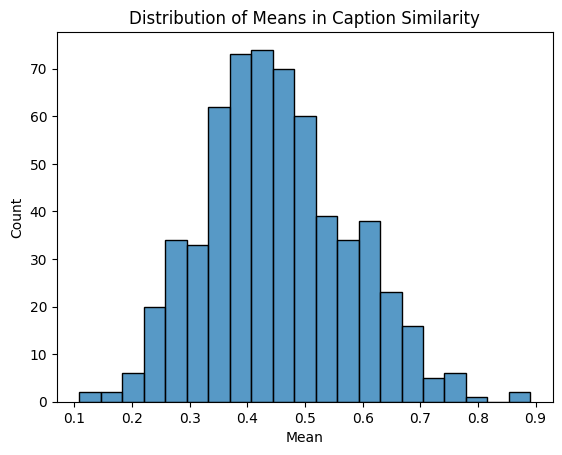

In [50]:
# plot mean similarity
sns.histplot(dataset_1, x="mean_similarity")
plt.title("Distribution of Means in Caption Similarity")
plt.xlabel("Mean")
plt.ylabel("Count")
plt.show()

In [51]:
# verify: image are unique
dataset_1["file_name"].nunique() == len(dataset_1)

True

In [52]:
# setup output path
output_path = "../../data/study-2-output/visual-interpreter-dataset/"
os.makedirs(output_path, exist_ok=True)

# save dataset_1 as a csv with everything
dataset1_raw = dataset_1.copy()
del dataset1_raw["evaluation"]
del dataset1_raw["human_caption_similarity"]
del dataset1_raw["sentences"]
del dataset1_raw["similarities"]
del dataset1_raw["pairwise_distances"]
dataset1_raw.to_csv(output_path + "dataset-1_raw.csv", index=False)

# make a formatted version of dataset_1
dataset_1_formatted = dataset_1[["file_name", "vizwiz_url"]].copy()
dataset_1_formatted.rename(
    columns={"file_name": "File Name", "vizwiz_url": "Image URL"}, inplace=True
)
dataset_1_formatted["Image Preview"] = ""
dataset_1_formatted[
    "Describe all parts of the image that may be important to a person who is blind."
] = ""
dataset_1_formatted[
    "If you are unable to enter a caption, describe the issue in this column."
] = ""
dataset_1_formatted.to_csv(output_path + "dataset-1_formatted.csv", index=False)

### Dataset 2: bottom 25% and top 25% mean similarity before 200 IQ
The idea behind this dataset is to select cases where human captioners agreed on a caption and where they did not. This is represented by low mean similarity between captions, and high mean similarity, respectively. This lets us target cases that might be hard for non-expert visual captioners to label and cases where untrained crowdworkers can caption more easily (as indicated by agreement. This does NOT say anything about the quality of the captions – captioners could agree, but all be wrong.

In [53]:
sample_size = 100
random_state = 42

In [54]:
q1, q3 = dataset_to_subset_df["mean_similarity"].quantile([0.25, 0.75])
print(f"Q1: {q1}")
print(f"Q3: {q3}")

remaining_sample_low = dataset_to_subset_df[
    dataset_to_subset_df["mean_similarity"] < q1
]
remaining_sample_high = dataset_to_subset_df[
    dataset_to_subset_df["mean_similarity"] > q3
]

Q1: 0.37005428969860077
Q3: 0.5455253273248672


In [55]:
# look at 25th percentile and over
remaining_sample_low_quality_counts = calculate_quality_metrics(
    remaining_sample_low,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
remaining_sample_low_quality_counts

combine_counts_and_percentages(remaining_sample_low_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,1054 (77.61%),342 (25.18%),213 (15.68%),1206 (88.81%),781 (57.51%),1136 (83.65%),1160 (85.42%)
1,240 (17.67%),190 (13.99%),161 (11.86%),117 (8.62%),126 (9.28%),164 (12.08%),142 (10.46%)
2,64 (4.71%),124 (9.13%),166 (12.22%),12 (0.88%),91 (6.70%),40 (2.95%),33 (2.43%)
3,0 (0.00%),96 (7.07%),174 (12.81%),5 (0.37%),89 (6.55%),4 (0.29%),8 (0.59%)
4,0 (0.00%),349 (25.70%),436 (32.11%),13 (0.96%),196 (14.43%),10 (0.74%),9 (0.66%)
5,0 (0.00%),257 (18.92%),208 (15.32%),5 (0.37%),75 (5.52%),4 (0.29%),6 (0.44%)
total,1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%)


In [56]:
# look at 75th percentile and over
remaining_sample_high_quality_counts = calculate_quality_metrics(
    remaining_sample_high,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
remaining_sample_high_quality_counts

combine_counts_and_percentages(remaining_sample_high_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,708 (52.14%),273 (20.10%),106 (7.81%),1141 (84.02%),719 (52.95%),1088 (80.12%),1093 (80.49%)
1,426 (31.37%),177 (13.03%),149 (10.97%),166 (12.22%),201 (14.80%),200 (14.73%),192 (14.14%)
2,224 (16.49%),131 (9.65%),200 (14.73%),20 (1.47%),149 (10.97%),49 (3.61%),46 (3.39%)
3,0 (0.00%),112 (8.25%),190 (13.99%),7 (0.52%),104 (7.66%),11 (0.81%),11 (0.81%)
4,0 (0.00%),356 (26.22%),522 (38.44%),15 (1.10%),144 (10.60%),8 (0.59%),13 (0.96%)
5,0 (0.00%),309 (22.75%),191 (14.06%),9 (0.66%),41 (3.02%),2 (0.15%),3 (0.22%)
total,1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%),1358 (100.00%)


In [57]:
# sample 100 images for rotation at low and high
rotation_sample_low = remaining_sample_low[remaining_sample_low["rotation"] >= 4]
rotation_sample_low_100 = rotation_sample_low.sample(
    n=sample_size, random_state=random_state
)
remaining_sample_low = remaining_sample_low[
    ~remaining_sample_low.index.isin(rotation_sample_low_100.index)
]

print(f"Sample size low: {len(rotation_sample_low_100)}")
print(f"Remaining sample size low: {len(remaining_sample_low)}")

rotation_sample_high = remaining_sample_high[remaining_sample_high["rotation"] >= 4]
rotation_sample_high_100 = rotation_sample_high.sample(
    n=sample_size, random_state=random_state
)
remaining_sample_high = remaining_sample_high[
    ~remaining_sample_high.index.isin(rotation_sample_high_100.index)
]

print(f"Sample size low: {len(rotation_sample_high_100)}")
print(f"Remaining sample size low: {len(remaining_sample_high)}")

Sample size low: 100
Remaining sample size low: 1258
Sample size low: 100
Remaining sample size low: 1258


In [58]:
# sample 100 images for blur at low and high
blur_sample_low = remaining_sample_low[remaining_sample_low["blur"] >= 4]
blur_sample_low_100 = blur_sample_low.sample(n=sample_size, random_state=random_state)
remaining_sample_low = remaining_sample_low[
    ~remaining_sample_low.index.isin(blur_sample_low_100.index)
]

print(f"Sample size low: {len(blur_sample_low_100)}")
print(f"Remaining sample size low: {len(remaining_sample_low)}")

blur_sample_high = remaining_sample_high[remaining_sample_high["blur"] >= 4]
blur_sample_high_100 = blur_sample_high.sample(n=sample_size, random_state=random_state)
remaining_sample_high = remaining_sample_high[
    ~remaining_sample_high.index.isin(blur_sample_high_100.index)
]

print(f"Sample size high: {len(blur_sample_high_100)}")
print(f"Remaining sample size high: {len(remaining_sample_high)}")

Sample size low: 100
Remaining sample size low: 1158
Sample size high: 100
Remaining sample size high: 1158


In [59]:
# sample 100 images for framing at low and high
framing_sample_low = remaining_sample_low[remaining_sample_low["framing"] >= 4]
framing_sample_low_100 = framing_sample_low.sample(
    n=sample_size, random_state=random_state
)
remaining_sample_low = remaining_sample_low[
    ~remaining_sample_low.index.isin(framing_sample_low_100.index)
]

print(f"Sample size low: {len(framing_sample_low_100)}")
print(f"Remaining sample size low: {len(remaining_sample_low)}")

# sample 100 images for framing at low and high
framing_sample_high = remaining_sample_high[remaining_sample_high["framing"] >= 4]
framing_sample_high_100 = framing_sample_high.sample(
    n=sample_size, random_state=random_state
)
remaining_sample_high = remaining_sample_high[
    ~remaining_sample_high.index.isin(framing_sample_high_100.index)
]

print(f"Sample size low: {len(framing_sample_low_100)}")
print(f"Remaining sample size low: {len(remaining_sample_low)}")

Sample size low: 100
Remaining sample size low: 1058
Sample size low: 100
Remaining sample size low: 1058


In [60]:
# construct sample such that each batch of 6 images has one from each IQ and hihg and low
batches_to_combine = []
for i in range(sample_size):
    # sample from low
    rotation_sample_low = rotation_sample_low_100.sample(n=1)
    blur_sample_low = blur_sample_low_100.sample(n=1)
    framing_sample_low = framing_sample_low_100.sample(n=1)

    # sample from high
    rotation_sample_high = rotation_sample_high_100.sample(n=1)
    blur_sample_high = blur_sample_high_100.sample(n=1)
    framing_sample_high = framing_sample_high_100.sample(n=1)

    # remove low samples
    rotation_sample_low_100 = rotation_sample_low_100[
        ~rotation_sample_low_100.index.isin(rotation_sample_low.index)
    ]
    blur_sample_low_100 = blur_sample_low_100[
        ~blur_sample_low_100.index.isin(blur_sample_low.index)
    ]
    framing_sample_low_100 = framing_sample_low_100[
        ~framing_sample_low_100.index.isin(framing_sample_low.index)
    ]

    # remove high samples
    rotation_sample_high_100 = rotation_sample_high_100[
        ~rotation_sample_high_100.index.isin(rotation_sample_high.index)
    ]
    blur_sample_high_100 = blur_sample_high_100[
        ~blur_sample_high_100.index.isin(blur_sample_high.index)
    ]
    framing_sample_high_100 = framing_sample_high_100[
        ~framing_sample_high_100.index.isin(framing_sample_high.index)
    ]

    # add curr, shuffled batch to batches_to_combine
    batches_to_combine.append(
        pd.concat(
            [
                rotation_sample_low,
                blur_sample_low,
                framing_sample_low,
                rotation_sample_high,
                blur_sample_high,
                framing_sample_high,
            ]
        ).sample(frac=1, replace=False, ignore_index=True)
    )

# combine all the samples
dataset_2 = pd.concat(batches_to_combine)
print(f"Dataset 2 size: {len(dataset_2)}")

# example quality counts
dataset_2_df_quality_counts = calculate_quality_metrics(
    dataset_2,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
dataset_2_df_quality_counts

combine_counts_and_percentages(dataset_2_df_quality_counts)

Dataset 2 size: 600


,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,402 (67.00%),150 (25.00%),82 (13.67%),529 (88.17%),262 (43.67%),499 (83.17%),501 (83.50%)
1,141 (23.50%),88 (14.67%),81 (13.50%),60 (10.00%),66 (11.00%),84 (14.00%),79 (13.17%)
2,57 (9.50%),55 (9.17%),77 (12.83%),6 (1.00%),32 (5.33%),14 (2.33%),14 (2.33%)
3,0 (0.00%),39 (6.50%),82 (13.67%),2 (0.33%),28 (4.67%),3 (0.50%),4 (0.67%)
4,0 (0.00%),154 (25.67%),195 (32.50%),3 (0.50%),158 (26.33%),0 (0.00%),2 (0.33%)
5,0 (0.00%),114 (19.00%),83 (13.83%),0 (0.00%),54 (9.00%),0 (0.00%),0 (0.00%)
total,600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%)


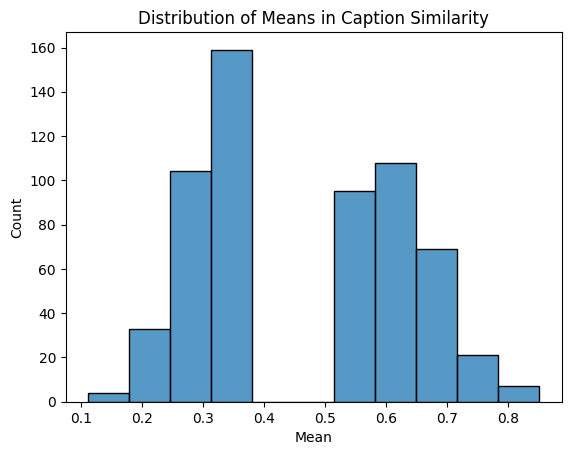

In [61]:
# plot mean similarity
sns.histplot(dataset_2, x="mean_similarity")
plt.title("Distribution of Means in Caption Similarity")
plt.xlabel("Mean")
plt.ylabel("Count")
plt.show()

In [62]:
# verify: image are unique
dataset_2["file_name"].nunique() == len(dataset_2)

True

In [63]:
# setup output path
output_path = "../../data/study-2-output/visual-interpreter-dataset/"
os.makedirs(output_path, exist_ok=True)

# save dataset_2 as a csv with everything
dataset2_raw = dataset_2.copy()
del dataset2_raw["evaluation"]
del dataset2_raw["human_caption_similarity"]
del dataset2_raw["sentences"]
del dataset2_raw["similarities"]
del dataset2_raw["pairwise_distances"]
dataset2_raw.to_csv(output_path + "dataset-2_raw.csv", index=False)

# make a formatted version of dataset_2
dataset_2_formatted = dataset_2[["file_name", "vizwiz_url"]].copy()
dataset_2_formatted.rename(
    columns={"file_name": "File Name", "vizwiz_url": "Image URL"}, inplace=True
)
dataset_2_formatted["Image Preview"] = ""
dataset_2_formatted[
    "Describe all parts of the image that may be important to a person who is blind."
] = ""
dataset_2_formatted[
    "If you are unable to enter a caption, describe the issue in this column."
] = ""
dataset_2_formatted.to_csv(output_path + "dataset-2_formatted.csv", index=False)

### Dataset 3: bottom 10% and top 10% mean similarity before 200 IQ

In [64]:
sample_size = 100
random_state = 42

In [65]:
q_low, q_high = dataset_to_subset_df["mean_similarity"].quantile([0.15, 0.85])
print(f"q_low: {q_low}")
print(f"q_high: {q_high}")

remaining_sample_low = dataset_to_subset_df[
    dataset_to_subset_df["mean_similarity"] < q_low
]
remaining_sample_high = dataset_to_subset_df[
    dataset_to_subset_df["mean_similarity"] > q_high
]

q_low: 0.32746848464012146
q_high: 0.5919422864913939


In [66]:
# look at low mean similarity
remaining_sample_low_quality_counts = calculate_quality_metrics(
    remaining_sample_low,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
remaining_sample_low_quality_counts

combine_counts_and_percentages(remaining_sample_low_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,623 (76.44%),212 (26.01%),135 (16.56%),727 (89.20%),463 (56.81%),682 (83.68%),690 (84.66%)
1,148 (18.16%),106 (13.01%),93 (11.41%),68 (8.34%),74 (9.08%),101 (12.39%),94 (11.53%)
2,44 (5.40%),77 (9.45%),93 (11.41%),5 (0.61%),59 (7.24%),20 (2.45%),17 (2.09%)
3,0 (0.00%),54 (6.63%),108 (13.25%),4 (0.49%),47 (5.77%),0 (0.00%),5 (0.61%)
4,0 (0.00%),212 (26.01%),268 (32.88%),9 (1.10%),129 (15.83%),8 (0.98%),5 (0.61%)
5,0 (0.00%),154 (18.90%),118 (14.48%),2 (0.25%),43 (5.28%),4 (0.49%),4 (0.49%)
total,815 (100.00%),815 (100.00%),815 (100.00%),815 (100.00%),815 (100.00%),815 (100.00%),815 (100.00%)


In [67]:
# look at high mean similarity
remaining_sample_high_quality_counts = calculate_quality_metrics(
    remaining_sample_high,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
remaining_sample_high_quality_counts

combine_counts_and_percentages(remaining_sample_high_quality_counts)

,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,394 (48.34%),149 (18.28%),55 (6.75%),681 (83.56%),427 (52.39%),664 (81.47%),652 (80.00%)
1,269 (33.01%),113 (13.87%),91 (11.17%),105 (12.88%),128 (15.71%),109 (13.37%),118 (14.48%)
2,152 (18.65%),82 (10.06%),133 (16.32%),11 (1.35%),90 (11.04%),28 (3.44%),28 (3.44%)
3,0 (0.00%),68 (8.34%),123 (15.09%),2 (0.25%),54 (6.63%),9 (1.10%),8 (0.98%)
4,0 (0.00%),222 (27.24%),305 (37.42%),10 (1.23%),90 (11.04%),4 (0.49%),7 (0.86%)
5,0 (0.00%),181 (22.21%),108 (13.25%),6 (0.74%),26 (3.19%),1 (0.12%),2 (0.25%)
total,815 (100.00%),815 (100.00%),815 (100.00%),815 (100.00%),815 (100.00%),815 (100.00%),815 (100.00%)


In [68]:
# sample 100 images for rotation at low and high
rotation_sample_low = remaining_sample_low[remaining_sample_low["rotation"] >= 4]
rotation_sample_low_100 = rotation_sample_low.sample(
    n=sample_size, random_state=random_state
)
remaining_sample_low = remaining_sample_low[
    ~remaining_sample_low.index.isin(rotation_sample_low_100.index)
]

print(f"Sample size low: {len(rotation_sample_low_100)}")
print(f"Remaining sample size low: {len(remaining_sample_low)}")

rotation_sample_high = remaining_sample_high[remaining_sample_high["rotation"] >= 4]
rotation_sample_high_100 = rotation_sample_high.sample(
    n=sample_size, random_state=random_state
)
remaining_sample_high = remaining_sample_high[
    ~remaining_sample_high.index.isin(rotation_sample_high_100.index)
]

print(f"Sample size low: {len(rotation_sample_high_100)}")
print(f"Remaining sample size low: {len(remaining_sample_high)}")

Sample size low: 100
Remaining sample size low: 715
Sample size low: 100
Remaining sample size low: 715


In [69]:
# sample 100 images for blur at low and high
blur_sample_low = remaining_sample_low[remaining_sample_low["blur"] >= 4]
blur_sample_low_100 = blur_sample_low.sample(n=sample_size, random_state=random_state)
remaining_sample_low = remaining_sample_low[
    ~remaining_sample_low.index.isin(blur_sample_low_100.index)
]

print(f"Sample size low: {len(blur_sample_low_100)}")
print(f"Remaining sample size low: {len(remaining_sample_low)}")

blur_sample_high = remaining_sample_high[remaining_sample_high["blur"] >= 4]
blur_sample_high_100 = blur_sample_high.sample(n=sample_size, random_state=random_state)
remaining_sample_high = remaining_sample_high[
    ~remaining_sample_high.index.isin(blur_sample_high_100.index)
]

print(f"Sample size high: {len(blur_sample_high_100)}")
print(f"Remaining sample size high: {len(remaining_sample_high)}")

Sample size low: 100
Remaining sample size low: 615
Sample size high: 100
Remaining sample size high: 615


In [70]:
# sample 100 images for framing at low and high
framing_sample_low = remaining_sample_low[remaining_sample_low["framing"] >= 4]
framing_sample_low_100 = framing_sample_low.sample(
    n=sample_size, random_state=random_state
)
remaining_sample_low = remaining_sample_low[
    ~remaining_sample_low.index.isin(framing_sample_low_100.index)
]

print(f"Sample size low: {len(framing_sample_low_100)}")
print(f"Remaining sample size low: {len(remaining_sample_low)}")

# sample 100 images for framing at low and high
framing_sample_high = remaining_sample_high[remaining_sample_high["framing"] >= 4]
framing_sample_high_100 = framing_sample_high.sample(
    n=sample_size, random_state=random_state
)
remaining_sample_high = remaining_sample_high[
    ~remaining_sample_high.index.isin(framing_sample_high_100.index)
]

print(f"Sample size low: {len(framing_sample_low_100)}")
print(f"Remaining sample size low: {len(remaining_sample_low)}")

Sample size low: 100
Remaining sample size low: 515
Sample size low: 100
Remaining sample size low: 515


In [71]:
# construct sample such that each batch of 6 images has one from each IQ and hihg and low
batches_to_combine = []
for i in range(sample_size):
    # sample from low
    rotation_sample_low = rotation_sample_low_100.sample(n=1)
    blur_sample_low = blur_sample_low_100.sample(n=1)
    framing_sample_low = framing_sample_low_100.sample(n=1)

    # sample from high
    rotation_sample_high = rotation_sample_high_100.sample(n=1)
    blur_sample_high = blur_sample_high_100.sample(n=1)
    framing_sample_high = framing_sample_high_100.sample(n=1)

    # remove low samples
    rotation_sample_low_100 = rotation_sample_low_100[
        ~rotation_sample_low_100.index.isin(rotation_sample_low.index)
    ]
    blur_sample_low_100 = blur_sample_low_100[
        ~blur_sample_low_100.index.isin(blur_sample_low.index)
    ]
    framing_sample_low_100 = framing_sample_low_100[
        ~framing_sample_low_100.index.isin(framing_sample_low.index)
    ]

    # remove high samples
    rotation_sample_high_100 = rotation_sample_high_100[
        ~rotation_sample_high_100.index.isin(rotation_sample_high.index)
    ]
    blur_sample_high_100 = blur_sample_high_100[
        ~blur_sample_high_100.index.isin(blur_sample_high.index)
    ]
    framing_sample_high_100 = framing_sample_high_100[
        ~framing_sample_high_100.index.isin(framing_sample_high.index)
    ]

    # add curr, shuffled batch to batches_to_combine
    batches_to_combine.append(
        pd.concat(
            [
                rotation_sample_low,
                blur_sample_low,
                framing_sample_low,
                rotation_sample_high,
                blur_sample_high,
                framing_sample_high,
            ]
        ).sample(frac=1, replace=False, ignore_index=True)
    )

# combine all the samples
dataset_3 = pd.concat(batches_to_combine)
print(f"Dataset 2 size: {len(dataset_3)}")

# example quality counts
dataset_3_df_quality_counts = calculate_quality_metrics(
    dataset_3,
    quality_columns=["unrecognizable"] + issues_to_filter,
)
dataset_3_df_quality_counts

combine_counts_and_percentages(dataset_3_df_quality_counts)

Dataset 2 size: 600


,unrecognizable,blur,framing,obstruction,rotation,too dark,too bright
0,401 (66.83%),146 (24.33%),85 (14.17%),520 (86.67%),261 (43.50%),509 (84.83%),512 (85.33%)
1,137 (22.83%),86 (14.33%),53 (8.83%),67 (11.17%),55 (9.17%),74 (12.33%),66 (11.00%)
2,62 (10.33%),59 (9.83%),87 (14.50%),6 (1.00%),47 (7.83%),14 (2.33%),14 (2.33%)
3,0 (0.00%),45 (7.50%),85 (14.17%),1 (0.17%),30 (5.00%),2 (0.33%),7 (1.17%)
4,0 (0.00%),152 (25.33%),198 (33.00%),5 (0.83%),151 (25.17%),0 (0.00%),1 (0.17%)
5,0 (0.00%),112 (18.67%),92 (15.33%),1 (0.17%),56 (9.33%),1 (0.17%),0 (0.00%)
total,600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%),600 (100.00%)


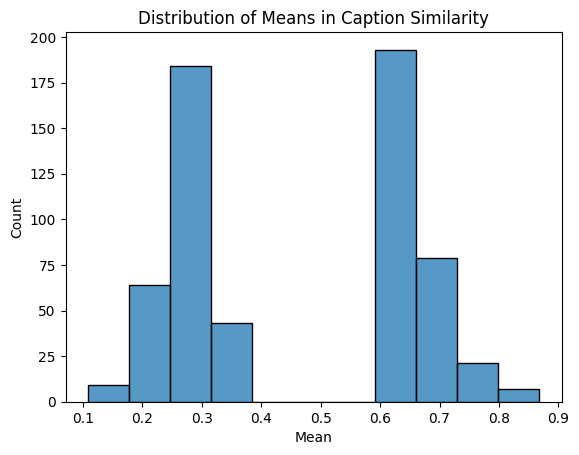

In [72]:
# plot mean similarity
sns.histplot(dataset_3, x="mean_similarity")
plt.title("Distribution of Means in Caption Similarity")
plt.xlabel("Mean")
plt.ylabel("Count")
plt.show()

In [73]:
# setup output path
output_path = "../../data/study-2-output/visual-interpreter-dataset/"
os.makedirs(output_path, exist_ok=True)

# save dataset_3 as a csv with everything
dataset3_raw = dataset_3.copy()
del dataset3_raw["evaluation"]
del dataset3_raw["human_caption_similarity"]
del dataset3_raw["sentences"]
del dataset3_raw["similarities"]
del dataset3_raw["pairwise_distances"]
dataset3_raw.to_csv(output_path + "dataset-3_raw.csv", index=False)

# make a formatted version of dataset_3
dataset_3_formatted = dataset_3[["file_name", "vizwiz_url"]].copy()
dataset_3_formatted.rename(
    columns={"file_name": "File Name", "vizwiz_url": "Image URL"}, inplace=True
)
dataset_3_formatted["Image Preview"] = ""
dataset_3_formatted[
    "Describe all parts of the image that may be important to a person who is blind."
] = ""
dataset_3_formatted[
    "If you are unable to enter a caption, describe the issue in this column."
] = ""
dataset_3_formatted.to_csv(output_path + "dataset-3_formatted.csv", index=False)